<a href="https://colab.research.google.com/github/labib899/text-to-code-seq2seq/blob/main/text_to_code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install datasets tqdm nltk seaborn

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
import nltk
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


In [2]:
# configs
MAX_SRC_LEN = 50
MAX_TGT_LEN = 80
BATCH_SIZE  = 64

EMBED_DIM   = 256
HIDDEN_DIM  = 256
DROPOUT     = 0.3

LEARNING_RATE        = 0.001
TEACHER_FORCING_RATIO= 0.5
EPOCHS               = 15
GRAD_CLIP            = 1
SEED                 = 42

SPECIAL_TOKENS = ["<pad>", "<sos>", "<eos>", "<unk>"]

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# load dataset
ds = load_dataset("Nan-Do/code-search-net-python")
full_data = ds["train"].shuffle(seed=SEED)
full_data = full_data.select(range(10000))

train_data = full_data.select(range(8000))
val_data   = full_data.select(range(8000, 9000))
test_data  = full_data.select(range(9000, 10000))

print(len(train_data), len(val_data), len(test_data))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-ee77a7de79eb2a(…):   0%|          | 0.00/155M [00:00<?, ?B/s]

data/train-00001-of-00004-648b3bede2edf6(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

data/train-00002-of-00004-1dfd72b171e6b2(…):   0%|          | 0.00/153M [00:00<?, ?B/s]

data/train-00003-of-00004-184ab6d0e3c690(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/455243 [00:00<?, ? examples/s]

8000 1000 1000


In [4]:
# tokenization and vocab
import re
from collections import Counter

def tokenize(text):
    return re.findall(r"\w+|[^\w\s]", text)

def build_vocab(data, field, max_vocab_size=20000):
    counter = Counter()
    for item in data:
        tokens = tokenize(item[field])
        counter.update(tokens)
    vocab = SPECIAL_TOKENS + [tok for tok, _ in counter.most_common(max_vocab_size)]
    stoi = {tok:i for i, tok in enumerate(vocab)}
    itos = {i:tok for tok,i in stoi.items()}
    return stoi, itos

src_stoi, src_itos = build_vocab(train_data, "docstring")
tgt_stoi, tgt_itos = build_vocab(train_data, "code")

print("Source vocab:", len(src_stoi), "Target vocab:", len(tgt_stoi))

Source vocab: 20004 Target vocab: 20004


In [5]:
# dataset and dataloader
class CodeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def encode(self, tokens, stoi, max_len):
        tokens = tokens[:max_len]
        ids = [stoi.get(tok, stoi["<unk>"]) for tok in tokens]
        ids = [stoi["<sos>"]] + ids + [stoi["<eos>"]]
        ids += [stoi["<pad>"]] * (max_len + 2 - len(ids))
        return torch.tensor(ids)

    def __getitem__(self, idx):
        item = self.data[idx]
        src_tokens = tokenize(item["docstring"])
        tgt_tokens = tokenize(item["code"])
        src_ids = self.encode(src_tokens, src_stoi, MAX_SRC_LEN)
        tgt_ids = self.encode(tgt_tokens, tgt_stoi, MAX_TGT_LEN)
        return src_ids, tgt_ids

    def __len__(self):
        return len(self.data)

train_loader = torch.utils.data.DataLoader(CodeDataset(train_data), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = torch.utils.data.DataLoader(CodeDataset(val_data), batch_size=BATCH_SIZE)
test_loader  = torch.utils.data.DataLoader(CodeDataset(test_data), batch_size=BATCH_SIZE)

In [6]:
# vanillaRNN
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        _, hidden = self.rnn(embedded)
        return hidden

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_token, hidden):
        embedded = self.embedding(input_token)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc(output)
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing_ratio=TEACHER_FORCING_RATIO):
        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]
        vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(device)
        hidden = self.encoder(src)
        input_token = tgt[:,0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input_token, hidden)
            outputs[:, t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input_token = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

In [7]:
# LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        _, (hidden, _) = self.rnn(embedded)
        return hidden

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_token, hidden):
        embedded = self.embedding(input_token)
        output, (hidden, cell) = self.rnn(embedded, (hidden, torch.zeros_like(hidden)))
        prediction = self.fc(output)
        return prediction, hidden

class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing_ratio=TEACHER_FORCING_RATIO):
        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(device)
        hidden = self.encoder(src)  # [1, batch, hidden_dim]

        input_token = tgt[:,0].unsqueeze(1)  # <sos>

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input_token, hidden)
            outputs[:, t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input_token = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

In [8]:
# LSTM + attention
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim*2 + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        hidden = hidden.permute(1,0,2).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

class EncoderBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.hidden_dim = hidden_dim

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        hidden = torch.tanh(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)).unsqueeze(0)
        return outputs, hidden

class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_hidden_dim, dec_hidden_dim, dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim + enc_hidden_dim*2, dec_hidden_dim, batch_first=True)
        self.fc = nn.Linear(enc_hidden_dim*2 + dec_hidden_dim + embed_dim, vocab_size)
        self.attention = BahdanauAttention(enc_hidden_dim, dec_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input_token))
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, torch.zeros_like(hidden)))
        output_fc = self.fc(torch.cat((output, weighted, embedded), dim=2))
        return output_fc, hidden, a.squeeze(1)

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing_ratio=TEACHER_FORCING_RATIO):
        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]
        vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(device)
        encoder_outputs, hidden = self.encoder(src)
        input_token = tgt[:,0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input_token = tgt[:, t].unsqueeze(1) if teacher_force else top1
        return outputs

In [10]:
# training and eval functions
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for src, tgt in loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        output_dim = output.shape[-1]
        loss = criterion(output[:,1:].reshape(-1, output_dim), tgt[:,1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            loss = criterion(output[:,1:].reshape(-1, output_dim), tgt[:,1:].reshape(-1))
            val_loss += loss.item()
    return val_loss / len(loader)

def decode_tokens(output_tensor):
    return [output_tensor.argmax(-1).cpu().item()]

def evaluate_metrics(model, loader, tgt_itos):
    model.eval()
    total_tokens = 0
    correct_tokens = 0
    references, hypotheses = [], []
    exact_matches = 0

    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0)
            pred_tokens = output.argmax(-1).cpu().numpy()
            tgt_tokens = tgt.cpu().numpy()

            # Token-level accuracy
            mask = tgt_tokens[:,1:] != tgt_stoi["<pad>"]
            correct_tokens += ((pred_tokens[:,1:] == tgt_tokens[:,1:]) * mask).sum()
            total_tokens += mask.sum()

            # BLEU
            for t, p in zip(tgt_tokens, pred_tokens):
                references.append([ [tgt_itos[i] for i in t if i not in [tgt_stoi["<pad>"], tgt_stoi["<sos>"], tgt_stoi["<eos>"]]] ])
                hypotheses.append([ tgt_itos[i] for i in p if i not in [tgt_stoi["<pad>"], tgt_stoi["<sos>"], tgt_stoi["<eos>"]]])

            # Exact Match
            for t, p in zip(tgt_tokens, pred_tokens):
                t_clean = [tgt_itos[i] for i in t if i not in [tgt_stoi["<pad>"], tgt_stoi["<sos>"], tgt_stoi["<eos>"]]]
                p_clean = [tgt_itos[i] for i in p if i not in [tgt_stoi["<pad>"], tgt_stoi["<sos>"], tgt_stoi["<eos>"]]]
                if t_clean == p_clean:
                    exact_matches += 1

    token_acc = correct_tokens / total_tokens
    bleu = corpus_bleu(references, hypotheses)
    exact_match = exact_matches / len(loader.dataset)
    return token_acc, bleu, exact_match

In [ ]:
# # train models
# from tqdm.notebook import tqdm

# model_configs = {
#     "VanillaRNN": (EncoderRNN(len(src_stoi), EMBED_DIM, HIDDEN_DIM),
#                    DecoderRNN(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM)),
#     "LSTM": (EncoderLSTM(len(src_stoi), EMBED_DIM, HIDDEN_DIM),
#              DecoderLSTM(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM)),
#     "Attention": (EncoderBiLSTM(len(src_stoi), EMBED_DIM, HIDDEN_DIM),
#                   DecoderLSTMWithAttention(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM, HIDDEN_DIM*2, DROPOUT))
# }

# results = {}

# for model_name, (encoder, decoder) in model_configs.items():
#     print(f"\n=== Training {model_name} ===")
#     if model_name == "VanillaRNN":
#       model = Seq2Seq(encoder, decoder).to(device)
#     elif model_name == "LSTM":
#         model = Seq2SeqLSTM(encoder, decoder).to(device)
#     else:  # Attention
#         model = Seq2SeqWithAttention(encoder, decoder).to(device)

#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     criterion = nn.CrossEntropyLoss(ignore_index=tgt_stoi["<pad>"])

#     best_val_loss = float("inf")
#     for epoch in range(EPOCHS):
#         # ---- Training ----
#         model.train()
#         train_loss = 0
#         loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
#         for src, tgt in loop:
#             src, tgt = src.to(device), tgt.to(device)
#             optimizer.zero_grad()
#             output = model(src, tgt)
#             output_dim = output.shape[-1]
#             loss = criterion(output[:,1:].reshape(-1, output_dim), tgt[:,1:].reshape(-1))
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
#             optimizer.step()
#             train_loss += loss.item()
#             loop.set_postfix(train_loss=train_loss/len(loop))

#         # ---- Validation ----
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for src, tgt in val_loader:
#                 src, tgt = src.to(device), tgt.to(device)
#                 output = model(src, tgt, teacher_forcing_ratio=0)
#                 output_dim = output.shape[-1]
#                 loss = criterion(output[:,1:].reshape(-1, output_dim), tgt[:,1:].reshape(-1))
#                 val_loss += loss.item()
#         val_loss /= len(val_loader)

#         print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), f"{model_name}_best.pth")
#             print("Saved checkpoint!")

#     # ---- Evaluation ----
#     model.load_state_dict(torch.load(f"{model_name}_best.pth"))
#     token_acc, bleu, exact = evaluate_metrics(model, test_loader, tgt_itos)
#     results[model_name] = {"Token Accuracy": token_acc, "BLEU": bleu, "Exact Match": exact}

In [ ]:
# print("\n=== Final Comparison ===")
# for model_name, metrics in results.items():
#     print(f"{model_name}: Token Acc: {metrics['Token Accuracy']*100:.2f}%, BLEU: {metrics['BLEU']:.2f}, Exact Match: {metrics['Exact Match']*100:.2f}%")

In [11]:
# train vanillaRNN
encoder = EncoderRNN(len(src_stoi), EMBED_DIM, HIDDEN_DIM)
decoder = DecoderRNN(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_stoi["<pad>"])
best_val_loss = float("inf")
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"VanillaRNN Epoch {epoch+1}/{EPOCHS}", leave=False)
    for src, tgt in loop:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        output_dim = output.shape[-1]
        loss = criterion(output[:,1:].reshape(-1, output_dim), tgt[:,1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        epoch_loss += loss.item()
        loop.set_postfix(train_loss=epoch_loss/len(loop))

    train_losses.append(epoch_loss/len(train_loader))
    val_loss = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "VanillaRNN_best.pth")
        torch.save({"train": train_losses, "val": val_losses}, "VanillaRNN_losses.pth")
        print("Saved Vanilla RNN checkpoint!")

Epoch 1: Train Loss=5.6841, Val Loss=5.2731
Saved Vanilla RNN checkpoint!


Epoch 2: Train Loss=4.8890, Val Loss=5.2110
Saved Vanilla RNN checkpoint!


Epoch 3: Train Loss=4.7042, Val Loss=5.2615


Epoch 4: Train Loss=4.5965, Val Loss=5.5368


Epoch 5: Train Loss=4.5211, Val Loss=5.6008


Epoch 6: Train Loss=4.4763, Val Loss=6.2858


Epoch 7: Train Loss=4.4247, Val Loss=5.4403


Epoch 8: Train Loss=4.3818, Val Loss=5.4322


Epoch 9: Train Loss=4.3290, Val Loss=5.5382


Epoch 10: Train Loss=4.2922, Val Loss=5.7733


Epoch 11: Train Loss=4.2673, Val Loss=5.6417


Epoch 12: Train Loss=4.2613, Val Loss=5.5696


Epoch 13: Train Loss=4.2176, Val Loss=5.5718


Epoch 14: Train Loss=4.2143, Val Loss=5.5752


Epoch 15: Train Loss=4.1814, Val Loss=5.5409


In [12]:
# train LSTM
encoder = EncoderLSTM(len(src_stoi), EMBED_DIM, HIDDEN_DIM)
decoder = DecoderLSTM(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM)
model = Seq2SeqLSTM(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_stoi["<pad>"])
best_val_loss = float("inf")
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"LSTM Epoch {epoch+1}/{EPOCHS}", leave=False)
    for src, tgt in loop:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        output_dim = output.shape[-1]
        loss = criterion(output[:,1:].reshape(-1, output_dim), tgt[:,1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        epoch_loss += loss.item()
        loop.set_postfix(train_loss=epoch_loss/len(loop))

    train_losses.append(epoch_loss/len(train_loader))
    val_loss = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "LSTM_best.pth")
        torch.save({"train": train_losses, "val": val_losses}, "LSTM_losses.pth")
        print("Saved LSTM checkpoint!")

Epoch 1: Train Loss=5.9555, Val Loss=5.3144
Saved LSTM checkpoint!


Epoch 2: Train Loss=4.9893, Val Loss=5.5948


Epoch 3: Train Loss=4.7923, Val Loss=5.1778
Saved LSTM checkpoint!


Epoch 4: Train Loss=4.6704, Val Loss=5.2182


Epoch 5: Train Loss=4.5886, Val Loss=5.4854


Epoch 6: Train Loss=4.5278, Val Loss=5.3826


Epoch 7: Train Loss=4.4743, Val Loss=5.4596


Epoch 8: Train Loss=4.4374, Val Loss=5.5176


Epoch 9: Train Loss=4.3982, Val Loss=5.5607


Epoch 10: Train Loss=4.3633, Val Loss=5.5290


Epoch 11: Train Loss=4.3234, Val Loss=5.5299


Epoch 12: Train Loss=4.2958, Val Loss=5.5074


Epoch 13: Train Loss=4.2740, Val Loss=5.6304


Epoch 14: Train Loss=4.2499, Val Loss=5.6408


Epoch 15: Train Loss=4.2171, Val Loss=5.3523


In [13]:
# train LSTM + attention
encoder = EncoderBiLSTM(len(src_stoi), EMBED_DIM, HIDDEN_DIM)
decoder = DecoderLSTMWithAttention(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM, HIDDEN_DIM*2, DROPOUT)
model = Seq2SeqWithAttention(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_stoi["<pad>"])
best_val_loss = float("inf")
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Attention Epoch {epoch+1}/{EPOCHS}", leave=False)
    for src, tgt in loop:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        output_dim = output.shape[-1]
        loss = criterion(output[:,1:].reshape(-1, output_dim), tgt[:,1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        epoch_loss += loss.item()
        loop.set_postfix(train_loss=epoch_loss/len(loop))

    train_losses.append(epoch_loss/len(train_loader))
    val_loss = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "Attention_best.pth")
        torch.save({"train": train_losses, "val": val_losses}, "Attention_losses.pth")
        print("Saved Attention checkpoint!")

Epoch 1: Train Loss=5.4630, Val Loss=5.2619
Saved Attention checkpoint!


Epoch 2: Train Loss=4.7431, Val Loss=5.4150


Epoch 3: Train Loss=4.4371, Val Loss=5.3156


Epoch 4: Train Loss=4.1352, Val Loss=5.2820


Epoch 5: Train Loss=3.8027, Val Loss=5.3438


Epoch 6: Train Loss=3.4940, Val Loss=5.2543
Saved Attention checkpoint!


Epoch 7: Train Loss=3.2036, Val Loss=5.1109
Saved Attention checkpoint!


Epoch 8: Train Loss=2.9939, Val Loss=5.3375


Epoch 9: Train Loss=2.8130, Val Loss=5.3152


Epoch 10: Train Loss=2.6811, Val Loss=5.4962


Epoch 11: Train Loss=2.5676, Val Loss=5.3470


Epoch 12: Train Loss=2.4569, Val Loss=5.3567


Epoch 13: Train Loss=2.3490, Val Loss=5.3327


Epoch 14: Train Loss=2.2850, Val Loss=5.3037


Epoch 15: Train Loss=2.1851, Val Loss=5.3932


In [15]:
# load models
def load_model(model_name):
    if model_name == "VanillaRNN":
        encoder = EncoderRNN(len(src_stoi), EMBED_DIM, HIDDEN_DIM)
        decoder = DecoderRNN(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM)
        model = Seq2Seq(encoder, decoder).to(device)
    elif model_name == "LSTM":
        encoder = EncoderLSTM(len(src_stoi), EMBED_DIM, HIDDEN_DIM)
        decoder = DecoderLSTM(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM)
        model = Seq2SeqLSTM(encoder, decoder).to(device)
    else:  # Attention
        encoder = EncoderBiLSTM(len(src_stoi), EMBED_DIM, HIDDEN_DIM)
        decoder = DecoderLSTMWithAttention(len(tgt_stoi), EMBED_DIM, HIDDEN_DIM, HIDDEN_DIM*2, DROPOUT)
        model = Seq2SeqWithAttention(encoder, decoder).to(device)

    model.load_state_dict(torch.load(f"{model_name}_best.pth"))
    model.eval()
    return model


vanilla_model = load_model("VanillaRNN")
lstm_model    = load_model("LSTM")
attn_model    = load_model("Attention")

In [16]:
# metrics
results = {}

for model_name, model in zip(["VanillaRNN","LSTM","Attention"], [vanilla_model,lstm_model,attn_model]):
    token_acc, bleu, exact = evaluate_metrics(model, test_loader, tgt_itos)
    results[model_name] = {"Token Accuracy": token_acc,
                           "BLEU": bleu,
                           "Exact Match": exact}

# Display
print("\n=== Model Comparison ===")
for model_name, metrics in results.items():
    print(f"{model_name}: Token Acc: {metrics['Token Accuracy']*100:.2f}%, BLEU: {metrics['BLEU']:.2f}, Exact Match: {metrics['Exact Match']*100:.2f}%")


=== Model Comparison ===
VanillaRNN: Token Acc: 12.63%, BLEU: 0.06, Exact Match: 0.00%
LSTM: Token Acc: 12.63%, BLEU: 0.06, Exact Match: 0.00%
Attention: Token Acc: 17.15%, BLEU: 0.19, Exact Match: 0.00%


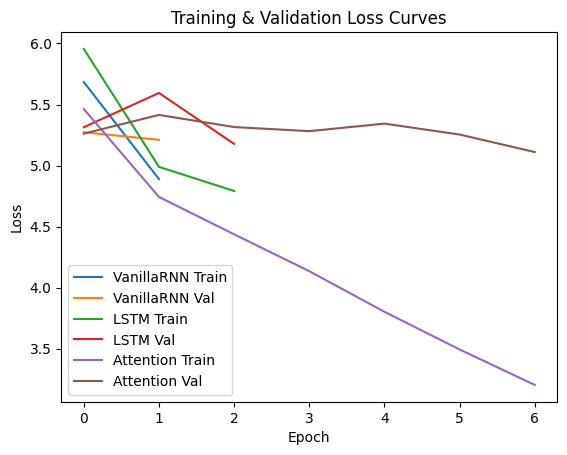

In [17]:
# loss curves
import matplotlib.pyplot as plt

for model_name in ["VanillaRNN", "LSTM", "Attention"]:
    losses = torch.load(f"{model_name}_losses.pth")
    plt.plot(losses["train"], label=f"{model_name} Train")
    plt.plot(losses["val"], label=f"{model_name} Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.show()

In [18]:
# analyze errors
def analyze_errors(model, loader):
    errors = {"syntax":0, "indent":0, "operators":0}
    total = 0
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0)
            pred_tokens = output.argmax(-1).cpu().numpy()
            tgt_tokens = tgt.cpu().numpy()
            for t, p in zip(tgt_tokens, pred_tokens):
                pred_code = " ".join([tgt_itos[i] for i in p if i not in [tgt_stoi["<pad>"], tgt_stoi["<sos>"], tgt_stoi["<eos>"]]])
                total += 1
                # Syntax check
                try:
                    compile(pred_code, "<string>", "exec")
                except SyntaxError:
                    errors["syntax"] += 1
                # Rough indentation check
                if pred_code.count("    ") % 4 != 0:
                    errors["indent"] += 1
                # Operator check
                for op in [">","<","+","-","*","/"]:
                    if op in pred_code:
                        break
                else:
                    errors["operators"] += 1
    for k in errors:
        errors[k] = errors[k]/total * 100
    return errors

vanilla_errors = analyze_errors(vanilla_model, test_loader)
lstm_errors    = analyze_errors(lstm_model, test_loader)
attn_errors    = analyze_errors(attn_model, test_loader)

print("Syntax/Indent/Operator errors (%)")
print("VanillaRNN:", vanilla_errors)
print("LSTM:", lstm_errors)
print("Attention:", attn_errors)

Syntax/Indent/Operator errors (%)
VanillaRNN: {'syntax': 100.0, 'indent': 0.0, 'operators': 0.0}
LSTM: {'syntax': 100.0, 'indent': 0.0, 'operators': 0.0}
Attention: {'syntax': 100.0, 'indent': 0.0, 'operators': 0.2}


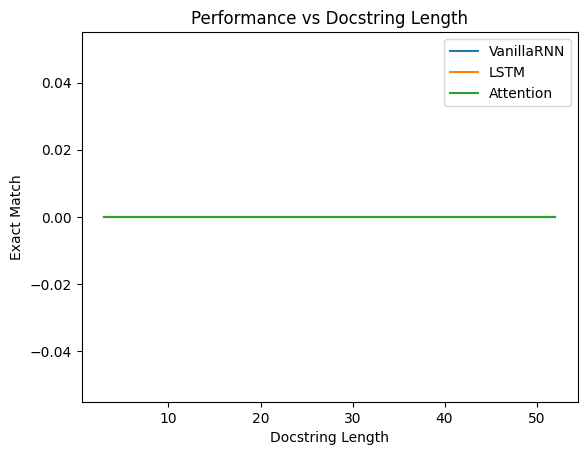

In [19]:
# performance vs docstring
import pandas as pd

def performance_vs_length(model, loader):
    lengths, exact_matches = [], []
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0)
            pred_tokens = output.argmax(-1).cpu().numpy()
            tgt_tokens = tgt.cpu().numpy()
            for s, t, p in zip(src, tgt_tokens, pred_tokens):
                doc_len = (s != src_stoi["<pad>"]).sum().item()
                t_clean = [tgt_itos[i] for i in t if i not in [tgt_stoi["<pad>"], tgt_stoi["<sos>"], tgt_stoi["<eos>"]]]
                p_clean = [tgt_itos[i] for i in p if i not in [tgt_stoi["<pad>"], tgt_stoi["<sos>"], tgt_stoi["<eos>"]]]
                exact_matches.append(int(t_clean == p_clean))
                lengths.append(doc_len)
    df = pd.DataFrame({"doc_len": lengths, "exact": exact_matches})
    return df.groupby("doc_len")["exact"].mean()

vanilla_perf = performance_vs_length(vanilla_model, test_loader)
lstm_perf    = performance_vs_length(lstm_model, test_loader)
attn_perf    = performance_vs_length(attn_model, test_loader)

plt.plot(vanilla_perf, label="VanillaRNN")
plt.plot(lstm_perf, label="LSTM")
plt.plot(attn_perf, label="Attention")
plt.xlabel("Docstring Length")
plt.ylabel("Exact Match")
plt.title("Performance vs Docstring Length")
plt.legend()
plt.show()

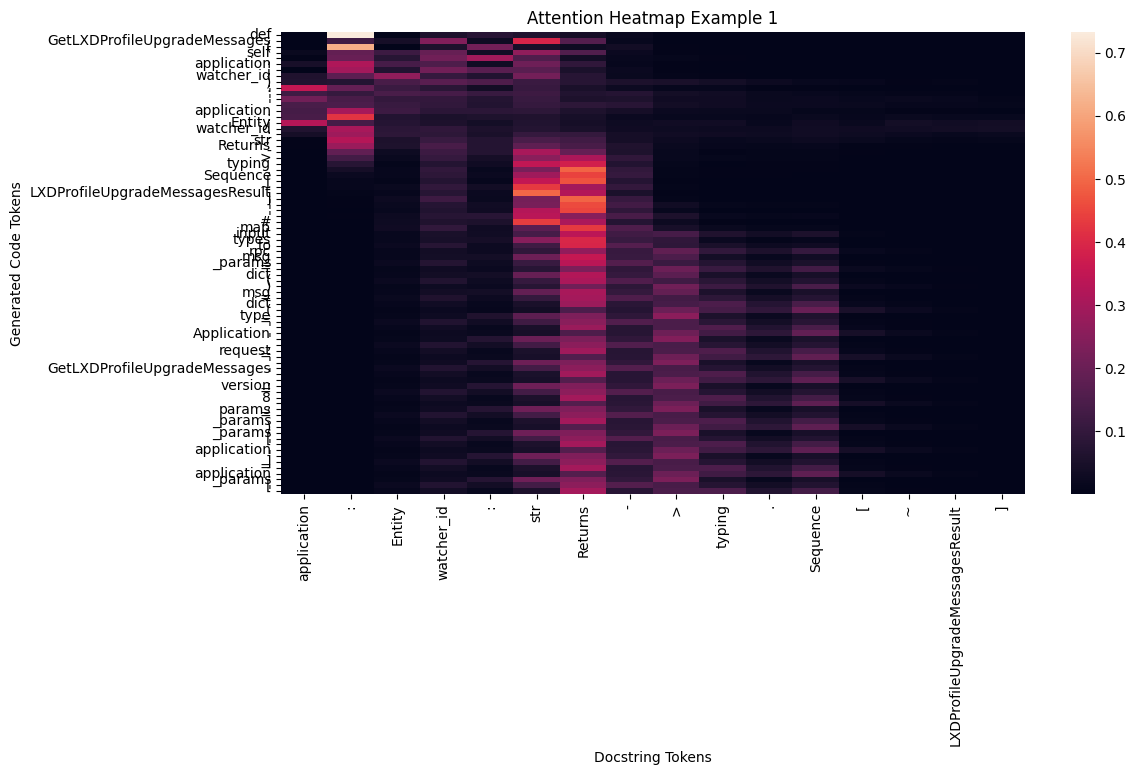

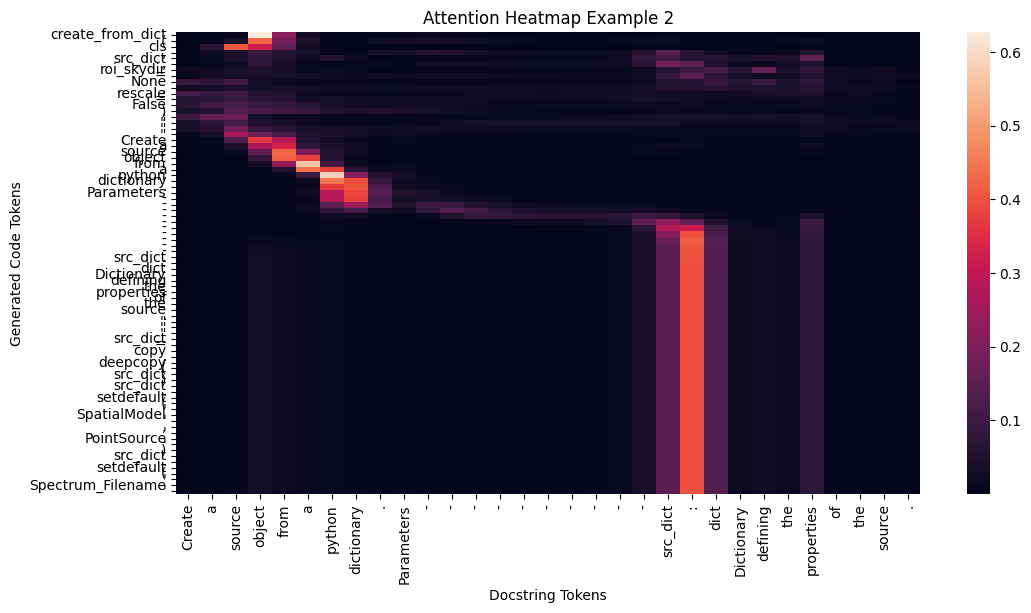

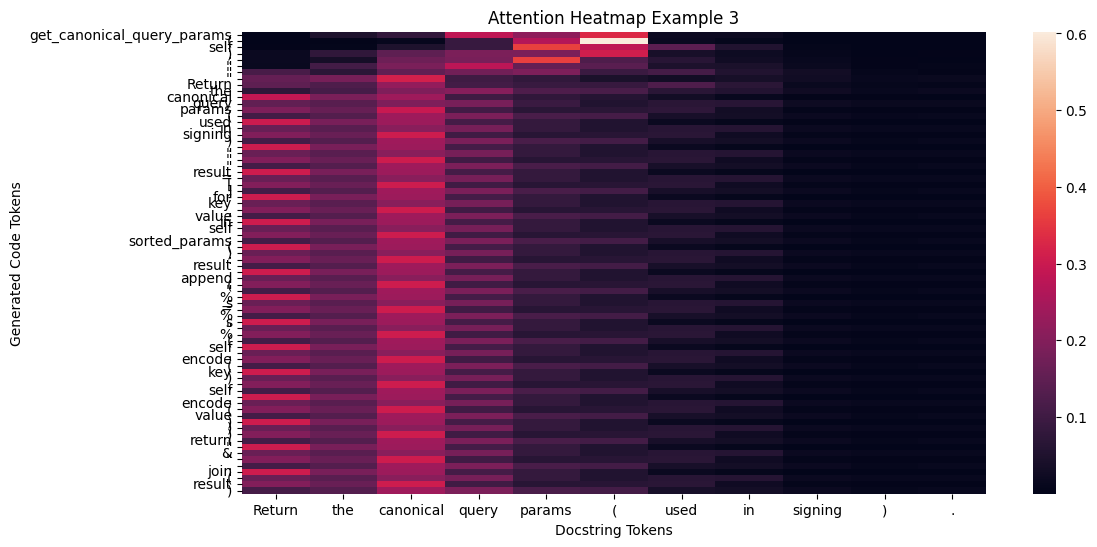

In [28]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def visualize_attention(model, src_ids, tgt_ids):
    model.eval()
    with torch.no_grad():
        # Get encoder outputs
        encoder_outputs, hidden = model.encoder(src_ids.unsqueeze(0).to(device))

        input_token = tgt_ids[0].unsqueeze(0).unsqueeze(0).to(device)  # <sos>
        attentions = []

        for t in range(1, len(tgt_ids)):
            output, hidden, attn = model.decoder(input_token, hidden, encoder_outputs)
            # attn shape: [batch, src_len] -> squeeze batch dimension
            attentions.append(attn.squeeze(0).cpu().numpy())
            top1 = output.argmax(2)
            input_token = top1

        return np.stack(attentions)  # shape: (tgt_len-1, src_len)

# Pick 3 test examples
for i in [0,1,2]:
    src_tokens = tokenize(test_data[i]["docstring"])[:MAX_SRC_LEN]
    tgt_tokens = tokenize(test_data[i]["code"])[:MAX_TGT_LEN]

    src_ids = torch.tensor([src_stoi.get(tok, src_stoi["<unk>"]) for tok in src_tokens])
    tgt_ids = torch.tensor([tgt_stoi.get(tok, tgt_stoi["<unk>"]) for tok in tgt_tokens])

    attention_matrix = visualize_attention(attn_model, src_ids, tgt_ids)

    # Now attention_matrix is 2D: (tgt_len-1, src_len)
    plt.figure(figsize=(12,6))
    sns.heatmap(attention_matrix, xticklabels=src_tokens, yticklabels=tgt_tokens[1:len(attention_matrix)+1])
    plt.xlabel("Docstring Tokens")
    plt.ylabel("Generated Code Tokens")
    plt.title(f"Attention Heatmap Example {i+1}")
    plt.show()

In [27]:
import os
import pickle
import json
import torch
import random
import numpy as np

os.makedirs("experiment_bundle", exist_ok=True)

# Save FINAL TRAINED MODELS
torch.save(vanilla_model.state_dict(), "experiment_bundle/VanillaRNN_final.pth")
torch.save(lstm_model.state_dict(), "experiment_bundle/LSTM_final.pth")
torch.save(attn_model.state_dict(), "experiment_bundle/Attention_final.pth")

print("Models saved.")

# save Vocab
with open("experiment_bundle/src_stoi.pkl", "wb") as f:
    pickle.dump(src_stoi, f)

with open("experiment_bundle/src_itos.pkl", "wb") as f:
    pickle.dump(src_itos, f)

with open("experiment_bundle/tgt_stoi.pkl", "wb") as f:
    pickle.dump(tgt_stoi, f)

with open("experiment_bundle/tgt_itos.pkl", "wb") as f:
    pickle.dump(tgt_itos, f)

print("Vocabulary saved.")

# save data split
torch.save(train_data, "experiment_bundle/train_data.pt")
torch.save(val_data, "experiment_bundle/val_data.pt")
torch.save(test_data, "experiment_bundle/test_data.pt")

print("Dataset splits saved.")

# save metrics
with open("experiment_bundle/final_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Metrics saved.")

# save config
config = {
    "MAX_SRC_LEN": MAX_SRC_LEN,
    "MAX_TGT_LEN": MAX_TGT_LEN,
    "BATCH_SIZE": BATCH_SIZE,
    "EMBED_DIM": EMBED_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "DROPOUT": DROPOUT,
    "LEARNING_RATE": LEARNING_RATE,
    "TEACHER_FORCING_RATIO": TEACHER_FORCING_RATIO,
    "EPOCHS": EPOCHS,
    "GRAD_CLIP": GRAD_CLIP,
    "SEED": SEED
}

with open("experiment_bundle/config.json", "w") as f:
    json.dump(config, f, indent=4)

print("Config saved.")

# save random state
rng_state = {
    "torch_rng_state": torch.get_rng_state(),
    "cuda_rng_state": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
    "numpy_rng_state": np.random.get_state(),
    "python_rng_state": random.getstate()
}

torch.save(rng_state, "experiment_bundle/rng_state.pth")

print("Random states saved.")

print("\nEVERYTHING SAVED INSIDE 'experiment_bundle' FOLDER")

Models saved.
Vocabulary saved.
Dataset splits saved.
Metrics saved.
Config saved.
Random states saved.

EVERYTHING SAVED INSIDE 'experiment_bundle' FOLDER


In [26]:
import os
import shutil

# Folder in Google Drive
drive_folder = "/content/drive/MyDrive/text2code_seq2seq"

# Create the folder if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)

# Copy your experiment folder (all models, losses, etc.)
shutil.copytree(
    "experiment_bundle",
    os.path.join(drive_folder, "experiment_bundle"),
    dirs_exist_ok=True
)

print(f"All files saved in {drive_folder}/experiment_bundle")

All files saved in /content/drive/MyDrive/text2code_seq2seq/experiment_bundle
